<a href="https://colab.research.google.com/github/AlessandroTenani02/work-dump/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers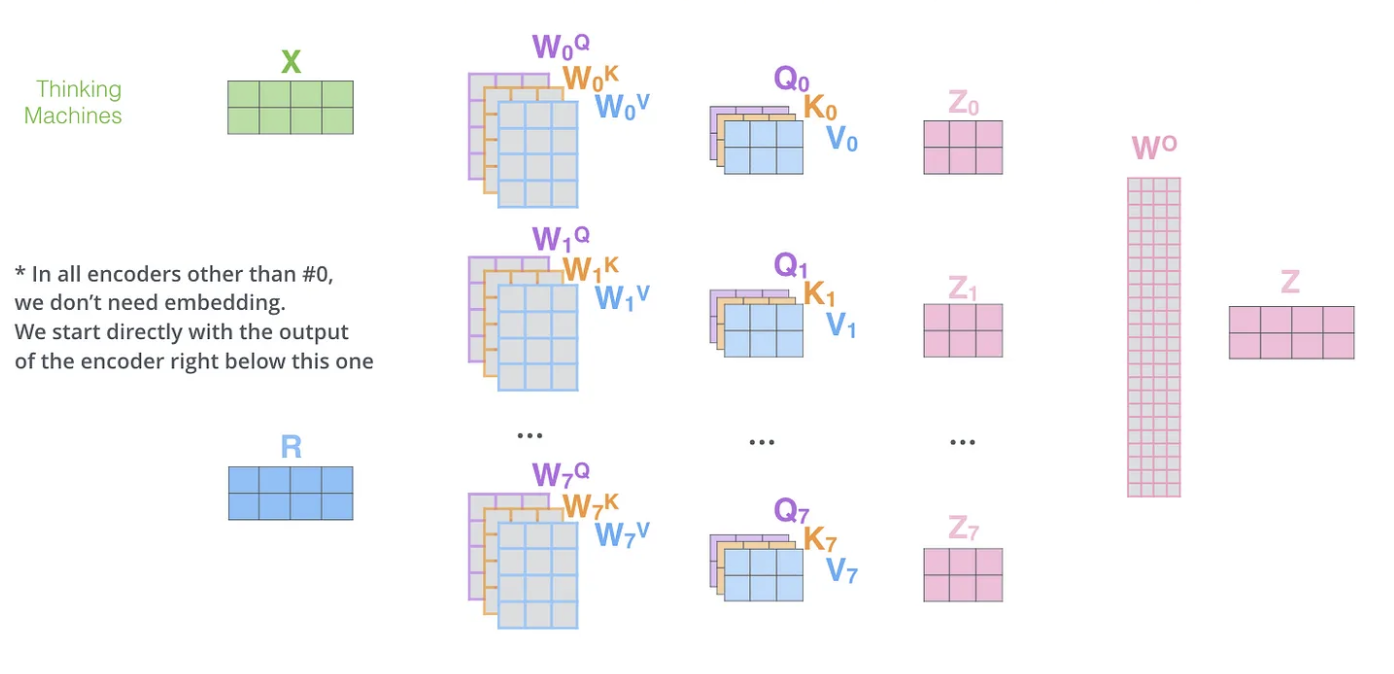

In [ ]:
!pip install cleantext

In [ ]:
import math
import numpy as np
import cleantext
import torch
import torch.nn as nn
import torchtext
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

url = 'https://raw.githubusercontent.com/niccosala-st/Text-Processing/main/spam_text_messages.csv'
df = pd.read_csv(url)

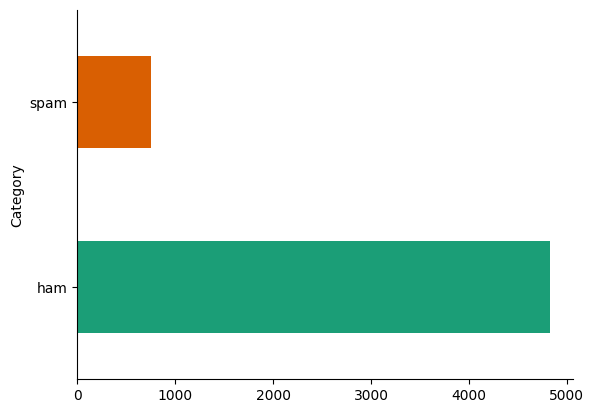

In [ ]:
# @title Category

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def clean_text(text_list):
    messages = []

    for message in text_list:
        corpus = cleantext.clean_words(message,
                              clean_all= False,    # Execute all cleaning operations
                              extra_spaces=True,   # Remove extra white spaces
                              stemming=True,       # Stem the words
                              stopwords=True,      # Remove stop words
                              lowercase=True,      # Convert to lowercase
                              numbers=False,       # Remove all digits
                              punct=True,          # Remove all punctuations
                              stp_lang='english'   # Language
        )
        cleaned_message = ' '.join(corpus)
        cleaned_message = re.sub("([\w\.\-\_]+@[\w\.\-\_]+)", "<EMAIL>", cleaned_message)
        cleaned_message = re.sub("(\d+)", "<NUMBER>", cleaned_message)
        cleaned_message = re.sub("(http\S+)", "<URL>", cleaned_message)
        cleaned_message = re.sub("(\s){2,}", "", cleaned_message)

        messages.append(cleaned_message)


    return messages

In [ ]:
df['Cleaned'] = clean_text(df['Message'])
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Category,Message,Cleaned
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri <NUMBER> wkli comp win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
print(df_train.head())

     Category                                            Message  \
1642      ham  Hi , where are you? We're at  and they're not ...   
2899      ham        If you r @ home then come down within 5 min   
480       ham  When're you guys getting back? G said you were...   
3485      ham  Tell my  bad character which u Dnt lik in me. ...   
157       ham                        I'm leaving my house now...   

                                                Cleaned  
1642  hi theyr keen go kind feel shouldnt go tomo do...  
2899                    r home come within <NUMBER> min  
480            whenr guy get back g said think stay mcr  
3485  tell bad charact u dnt lik ill tri chang ltgt ...  
157                                        im leav hous  


In [ ]:
labels = df_train['Category'].unique()
id_label = dict()
for i, label in enumerate(labels):
  id_label[i] = label

print(id_label)

{0: 'ham', 1: 'spam'}


In [ ]:
tokenizer = get_tokenizer('basic_english')

# Initialize training data iterator
class TextIter(torch.utils.data.Dataset):

  def __init__(self, input_data):
      self.text = input_data['Message'].values.tolist()
  def __len__(self):
      return len(self.text)
  def __getitem__(self, index):
      return self.text[index]

# Build vocabulary
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

data_iter = TextIter(df_train)
vocab = build_vocab_from_iterator(yield_tokens(data_iter), specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])
print(vocab.get_itos())

['<pad>', '<unk>', '.', 'i', 'to', 'you', ',', "'", '?', 'a', '!', 'the', 'u', 'and', 'is', 'in', 'me', 'it', 'my', 'for', 'your', 'of', 'that', 'call', 'have', 's', 'on', '2', ')', 'now', 'are', 'can', 'so', 'not', 'but', 'm', 'do', 'or', 'if', 'get', 'ur', 'with', 't', 'at', 'be', 'we', 'will', 'just', 'no', 'this', '&lt', 'up', 'how', 'when', 'ok', 'from', 'go', '4', '#&gt', 'what', 'out', 'free', 'll', 'all', 'know', 'like', 'good', 'got', 'then', 'its', 'was', 'am', 'come', 'he', 'only', 'day', '-', 'time', 'love', 'there', 'want', 'text', 'send', 'as', 'by', 'going', 'ü', 'about', 'one', 'she', 'need', 'home', 'stop', 'txt', 'back', 'today', 'lor', 'still', 'da', 'sorry', 'don', 'see', 'dont', 'r', 'our', 'later', 'n', 'tell', 'k', 'any', 'take', 'reply', 'pls', 'they', 'think', 'her', 'hi', 'please', 'did', 'new', 'phone', 'been', 'mobile', 'has', 'who', '(', 'an', 'dear', 'oh', 'd', 'here', 'night', 'week', 'some', 'where', 'great', 'well', 'him', 'much', 'too', 'give', 'had', 

Il **layer di embedding** trasforma il vocabolario in uno spazio vettoriale, in cui ogni parola è un vettore. <br> I vettori saranno tanto più vicini nello spazio vettoriale quanto più spesso le parole associate sono utilizzate nello stesso contesto. In questo modo si fa un'analisi semantica del vocabolario. <br>
Ogni token del vocabolario diventa un vettore di lunghezza *d*. <br>
Passando il vocabolario al layer di embedding, si ottiene un tensore di forma <br>(*batch* x *sequenza* x *d*).

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Embeddings, self).__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, vocab_size, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout) # ignora alcuni nodi alla volta e riduce overfitting

        # matrice di encoding posizionale
        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        print(position)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

Il **layer di codifica posizionale** è una componente essenziale nell'architettura del Transformer.<br> Aggiunge informazioni sulla posizione delle parole all'interno della sequenza di input, considerando che <br> il Transformer non possiede una comprensione intrinseca dell'ordine delle parole.



In [ ]:
class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, d_head_size):
        super().__init__()
        self.lin_key = nn.Linear(d_model, d_head_size, bias=False)
        self.lin_query = nn.Linear(d_model, d_head_size, bias=False)
        self.lin_value = nn.Linear(d_model, d_head_size, bias=False)
        self.d_model = d_model

    def forward(self, x):
        query = self.lin_query(x)
        key = self.lin_key(x)
        value = self.lin_value(x)

        print("Query size:", query.size())
        print("Key size:", key.size())
        print("Value size:", value.size())

        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_model)
        print("Scores size:", scores.size())
        p_attn = scores.softmax(dim=-1)
        print("Softmax size:", p_attn.size())
        x = torch.matmul(p_attn, value)
        print("Output size:", x.size())

        return x

Il **layer di attention** è il punto nevralgico di un Transformer. Dai tensori si ricavano matrici *query*, *key* e *value*. <br>
Si calcola poi una quarta matrice che contiene score di correlazione fra le parole (l'**attenzione**).<br>
Tale matrice Z è calcolata moltiplicando le matrici di query e key, dividendo il risultato per la radice della dimensione <br> degli embeddings. Si applica la softmax per ottenere i pesi dell'attenzione, per poi moltiplicarli per la matrice value.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0
        d_k = d_model // h
        self.multi_head = nn.ModuleList([SingleHeadAttention(d_model, d_k) for _ in range(h)])
        self.lin_agg = nn.Linear(d_model, d_model)

    def forward(self, x):
        x = torch.cat([head(x) for head in self.multi_head], dim=-1)
        return self.lin_agg(x)

La **multi-headed attention** utilizza diversi layer di attention, per poi concatenare le matrici prodotte e moltiplicarle per una matrice di pesi W, ottenendo così una matrice delle stesse dimensioni della **single-headed attention**.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(d_model))
        self.b_2 = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class ResidualConnection(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x1, x2):
        return self.dropout(self.norm(x1 + x2))

Il layer di **Resudual Connection** fa sì che i gradienti, passando per i layer della rete neurale, non scompaiano *(i gradienti sono soliti diventare piccoli ed ininfluenti per la modifica dei pesi attraverso i layers)*.<br> La residual connection serve a preservare l'informazione originale durante la trasformazione, in quanto permette ai gradienti di fluire attraverso gli strati della rete neurale.

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

Il **FeedForward** network viene utilizzato per elaborare e trasformare gli embedding di input dopo l'attenzione. Questo migliora le prestazioni del modello in termini di elaborazione della semantica del linguaggio naturale.

In [ ]:
class Classifier(nn.Module):
    def __init__(self, d_model, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        return torch.nn.functional.softmax(self.fc(x), dim=-1)

Un comune classificatore da utilizzare con i Transformers è un **fully connected layer**.

Questo classificatore lineare prende in input l'output dell'encoder e lo proietta in uno spazio di <br> dimensione pari al *numero di classi* nel problema di classificazione. <br> Si usa la *softmax* per ottenere la probabilità di appartenenza alle classi.

L'**Encoder**, infine, mette tutto in pipeline.

In [ ]:
class SingleEncoder(nn.Module):
    def __init__(self, d_model, emb, pos_encoder, self_attn, feed_forward, classifier, dropout):
        super().__init__()
        self.emb = emb
        self.pos_encoder = pos_encoder
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.res_1 = ResidualConnection(d_model, dropout)
        self.res_2 = ResidualConnection(d_model, dropout)
        self.outputs = classifier


        self.d_model = d_model

    def forward(self, x):
        emb = self.emb(x)
        pos_encoder = self.pos_encoder(emb)
        x_attn = self.self_attn(pos_encoder)
        x_res_1 = self.res_1(pos_encoder, x_attn)
        x_ff = self.feed_forward(x_res_1)
        x_res_2 = self.res_2(x_res_1, x_ff)
        outputs = self.outputs(x_res_2)

        return outputs

In [ ]:
class EncoderBlocks(nn.Module):
    def __init__(self, layer, N):
        super().__init__()
        self.layers = nn.ModuleList([layer for _ in range(N)])
        self.norm = LayerNorm(layer.d_model)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

## Fase di train e test

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

Definiamo il modello:


*   Dimensione degli embeddings: 128
*   Dropout (previene overfitting): 0.1
*   Dimensione dello strato nascosto della FeedForward network: 512
* Batch length: 64
*   Epoche: 5



In [ ]:
d_model = 128
vocab_size = len(vocab)
dropout = 0.1
epochs = 5
d_ff = 512
batch = 64

embeddings = Embeddings(d_model, vocab_size)
pos_encoding = PositionalEncoding(d_model, vocab_size, dropout)
attention = MultiHeadAttention(h=8, d_model=d_model, dropout=dropout)
feed_forward = FeedForward(d_model, d_ff=d_ff, dropout=dropout)
classifier = Classifier(d_model, 2) # numero di classi
encoder = SingleEncoder(d_model, embeddings, pos_encoding, attention,
                        feed_forward, classifier, dropout)

tensor([[0.0000e+00],
        [1.0000e+00],
        [2.0000e+00],
        ...,
        [8.1110e+03],
        [8.1120e+03],
        [8.1130e+03]])


Si costruisce il dataset da usare per allenare e testare il modello sopra definito. <br>
Il **data loader** è un'utility di PyTorch che permette la suddivisione dei dati in batch.

In [ ]:
# Train dataset
label_encoder = LabelEncoder()

encoded_strings_train = [[vocab[token] for token in message.split()] for message in df_train['Cleaned']]
max_length = max(len(ls) for ls in encoded_strings_train)
encoded_strings_train_ds = [ls + [0] * (max_length - len(ls)) for ls in encoded_strings_train]

encoded_labels_train_ds = label_encoder.fit_transform(df_train['Category'])

train_dataset = TensorDataset(torch.tensor(encoded_strings_train_ds), torch.tensor(encoded_labels_train_ds))
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

# Test dataset
encoded_strings_test = [[vocab[token] for token in message.split()] for message in df_test['Cleaned']]
max_length = max(len(ls) for ls in encoded_strings_test)
encoded_strings_test_ds = [ls + [0] * (max_length - len(ls)) for ls in encoded_strings_test]

encoded_labels_test_ds = label_encoder.fit_transform(df_test['Category'])

test_dataset = TensorDataset(torch.tensor(encoded_strings_test_ds), torch.tensor(encoded_labels_test_ds))
test_dataloader = DataLoader(test_dataset, batch_size=batch)

**Fase di training:** <br>
Si usa l'algoritmo di ottimizzazione Adam per un migliore aggiornamento dei pesi durante l'addestramento.

In [ ]:
optimizer = optim.Adam(encoder.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = epochs
for epoch in range(num_epochs):
    for inputs, labels in train_dataloader:
        print(inputs.size())
        print(labels.size())
        optimizer.zero_grad()
        outputs = encoder(inputs)
        labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=2)
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()

Output streaming troncato alle ultime 5000 righe.
Softmax size: torch.Size([64, 80, 80])
Output size: torch.Size([64, 80, 16])
Input sizez: torch.Size([64, 80, 128])
Input sizezz: torch.Size([64, 80, 128])
Query size: torch.Size([64, 80, 16])
Key size: torch.Size([64, 80, 16])
Value size: torch.Size([64, 80, 16])
Scores size: torch.Size([64, 80, 80])
Softmax size: torch.Size([64, 80, 80])
Output size: torch.Size([64, 80, 16])
Input sizez: torch.Size([64, 80, 128])
Input sizezz: torch.Size([64, 80, 128])
Query size: torch.Size([64, 80, 16])
Key size: torch.Size([64, 80, 16])
Value size: torch.Size([64, 80, 16])
Scores size: torch.Size([64, 80, 80])
Softmax size: torch.Size([64, 80, 80])
Output size: torch.Size([64, 80, 16])
Input sizez: torch.Size([64, 80, 128])
Input sizezz: torch.Size([64, 80, 128])
Query size: torch.Size([64, 80, 16])
Key size: torch.Size([64, 80, 16])
Value size: torch.Size([64, 80, 16])
Scores size: torch.Size([64, 80, 80])
Softmax size: torch.Size([64, 80, 80])
Ou

**Fase di test:**

In [ ]:
predictions = []
true_labels = []
label_to_encoding = {'ham': 1, 'spam': 0}

for inputs, labels in test_dataloader:
    outputs = encoder(inputs)
    predicted_labels = torch.argmax(outputs, dim=2)[:, 0]
    #print(outputs)
    #print(predicted_labels)
    l = [label_to_encoding[label] for label in labels.tolist()]
    print(l)
    predictions.extend(predicted_labels.tolist())
    true_labels.extend([label_to_encoding[label] for label in labels.tolist()])
    print(predicted_labels)
    print(true_labels)
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# TP, TN, FP, FN
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

Input sizez: torch.Size([64, 66, 128])
Input sizezz: torch.Size([64, 66, 128])
Query size: torch.Size([64, 66, 16])
Key size: torch.Size([64, 66, 16])
Value size: torch.Size([64, 66, 16])
Scores size: torch.Size([64, 66, 66])
Softmax size: torch.Size([64, 66, 66])
Output size: torch.Size([64, 66, 16])
Input sizez: torch.Size([64, 66, 128])
Input sizezz: torch.Size([64, 66, 128])
Query size: torch.Size([64, 66, 16])
Key size: torch.Size([64, 66, 16])
Value size: torch.Size([64, 66, 16])
Scores size: torch.Size([64, 66, 66])
Softmax size: torch.Size([64, 66, 66])
Output size: torch.Size([64, 66, 16])
Input sizez: torch.Size([64, 66, 128])
Input sizezz: torch.Size([64, 66, 128])
Query size: torch.Size([64, 66, 16])
Key size: torch.Size([64, 66, 16])
Value size: torch.Size([64, 66, 16])
Scores size: torch.Size([64, 66, 66])
Softmax size: torch.Size([64, 66, 66])
Output size: torch.Size([64, 66, 16])
Input sizez: torch.Size([64, 66, 128])
Input sizezz: torch.Size([64, 66, 128])
Query size: 

KeyError: 0